______________________________________________________________________________________________________________________________________________________________________________________________
# Imports required for running environment and code
______________________________________________________________________________________________________________________________________________________________________________________________

In [ ]:
!pip install gymnasium
!pip install stable-baselines3
!pip install sb3-contrib

In [1]:
import gymnasium
from gymnasium.spaces import Box
import numpy as np
import pandas as pd
import yfinance as yf
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime, timedelta
import random
from stable_baselines3.common.callbacks import BaseCallback
from tqdm.auto import tqdm
import torch
from typing import Callable
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO, TD3 
from sb3_contrib import TRPO
from stable_baselines3.common.noise import NormalActionNoise
import os


______________________________________________________________________________________________________________________________________________________________________________________________
# Stock Trading Environment

Included in this notebook is the environment we used to simulate a stock environment

This environment is broken down into 2 classes: the base class and Ryan's Environment subclass. 

This was because during development, to allow for easier experimentation on how different reward functions and observations affected the model performance, each member of the group had their own environment which inherited from the base class, allowing each of us to perform our own experiments on the reward function without disrupting each other's code. Within this notebook, a version of Ryan's environment with the best performing reward function created was included due to the reward function being the most successful in generating high performing agents.
______________________________________________________________________________________________________________________________________________________________________________________________

## Base Environment Class

The base class is responsible for all the common elements required to create a successful stock trading environment which were not changed within the personal environments

There are a number of important functions performed by the base environment

The __init__() function sets up the main parameters of our stock environment including:
*    The start and end dates of our trading period
*    The dimensions and ranges of our observation space
*    The dimensions and ranges of our action space
*    The amount of funds available
*    The different trading days and their associated stock prices (this data is downloaded when the environment is first created)

The render functions are used to display the performance of a episode over the complete timeframe of the trading period, and will be used during evaluation to create graphs such as this:

<img src="model_perf.png" alt="drawing" width="800"/>



In [2]:
PERIOD = 20

class SimpleTrader(gymnasium.Env):

    '''
    BASIC STOCK TRADER:
    - passed a list of stock tickers to invest in
    - passed an initial amount of funds to invest
    - for each stock, the action selected by the agent is a float, <0 means
    selling that many shares of a stock, > 0 means buying that many shares of a
    stock and 0 means holding
    - action space -> between -1 (sell all shares) and 1 (buy all shares), 0 is
    hold
    - observation space -> current funds, number of shares owned for each stock
    '''

    # required by gym
    metadata = {"render.modes": ["human", "graph", "review"]}

    def __init__(self, ticker_list, initial_funds=2000, observation_metrics=3, starting_date="2023-04-05", ending_date="2023-10-05"):
        super().__init__()

        self.starting_date = starting_date
        self.ending_date = ending_date

        self.ticker_list = ticker_list
        self.num_stocks = len(self.ticker_list)

        self.stock_data = self._get_stock_data()

        self.state_space_dim = observation_metrics * self.num_stocks + 1

        all_days = pd.date_range(
            start=self.starting_date, end=self.ending_date, freq="B")
        actual_days = self.stock_data.index.get_level_values("Date").unique()

        self.trading_days = all_days.intersection(actual_days)

        self.num_trading_days = len(self.trading_days)

        self.action_history = []

        # buy, sell, shares or hold for each stock
        self.action_space = Box(low=-1,
                                high=1,
                                shape=(self.num_stocks,))

        self.observation_space = Box(low=-np.inf, high=np.inf,
                                     shape=(self.state_space_dim,))

        self.initial_funds = initial_funds
        self.previous_portfolio = self.initial_funds

        self.total_buy_percents = []
        self.total_sell_percents = []

        self.total_buy_actions = []
        self.total_sell_actions = []

        self.reset()

    def render(self, mode):
        if mode == "human":
            print("=" * 20)
            print(f"Current Step: {self.curr_step} / {self.num_trading_days}")
            print(
                f"Current Profit / Loss: {self.curr_funds - self.initial_funds}")

            curr_date = self.trading_days[self.curr_step - 1]

            for stock in range(self.num_stocks):
                print(
                    f"Shares of {self.ticker_list[stock]} owned: {self.owned_shares[stock]}")
                print(
                    f"Opening Price for {self.ticker_list[stock]}: {self.stock_data.loc[(self.ticker_list[stock], curr_date) ,'Open']}")
                print(
                    f"Adjusted Closing Price for {self.ticker_list[stock]}: {self.stock_data.loc[(self.ticker_list[stock], curr_date), 'Adj Close']}")
            print(f"Portfolio Value: {self.portfolio_value}")
            print("=" * 20)

        if mode == 'review':
            self._render_on_completion()

    def set_render_episodes(self, flag):
        self.render_episodes = flag

    def _get_total_action_count(self):
        self.total_buy_actions.append(self.num_buys)
        self.total_sell_actions.append(self.num_sells)

    def _get_total_buy_sell_percents(self):
        if self.num_buys != 0:
            self.total_buy_percents.append(self.buy_percents / self.num_buys)

        if self.num_sells != 0:
            self.total_sell_percents.append(
                self.sell_percents / self.num_sells)

    def _render_on_completion(self):

        fig, axs = plt.subplots(nrows=2, figsize=(15, 10))

        avg_valuation = [round(sum(values) / len(values), 4)
                         for values in zip(*self.portfolio_history)]

        max_valuation = [(ii + 1, max(episode)) for ii, episode in enumerate(self.portfolio_history)]
        max_valuation.sort(key=lambda x: x[1])

        for _, episode_portfolio in enumerate(self.portfolio_history):
            axs[0].plot(episode_portfolio, color="grey", alpha=0.3, linewidth=2)

        axs[0].plot(avg_valuation, color="red",
                    linewidth=2, marker="o", markersize=4)

        axs[0].set_title(
            f"Average Portfolio Valuation over {len(self.portfolio_history)} Episodes")
        axs[0].set_xlabel("Trading Day")
        axs[0].set_ylabel("Portfolio Valuation ($)")

        episodes, values = zip(*max_valuation)
        col = ["red" if value == max(values) else "grey" for value in values]

        axs[1].bar(range(len(max_valuation)), values, color=col)
        axs[1].set_xticks(range(len(max_valuation)))
        axs[1].set_xticklabels(episodes)
        axs[1].set_title(f"Max Portfolio Valuation per {len(self.portfolio_history)} Episodes")
        axs[1].set_xlabel("Episode")
        axs[1].set_ylabel("Portfolio Valuation ($)")

        plt.tight_layout()
        plt.show()
        fig.savefig("model_perf.png")

        print(
            f"AVERAGE VALUATION: {round(sum(avg_valuation) / len(avg_valuation), 3)}")

        print(
            f"AVERAGE MAX VALUATION: {round(sum(values) / len(values), 3)}")

        print(
            f"ON AVERAGE, AGENT \033[1m\033[92mBOUGHT\033[0m {int(sum(self.total_buy_actions) / len(self.total_buy_actions))} TIMES AND \033[1m\033[91mSOLD\033[0m {int(sum(self.total_sell_actions) / len(self.total_sell_actions))} TIMES")
        print(f"Buy actions: {self.total_buy_actions}")
        print(f"Sell actions: {self.total_sell_actions}")
        print(f"Average buy percents: {[round(value, 3) for value in self.total_buy_percents]}")
        print(f"Average sell percents: {[round(value, 3) for value in self.total_sell_percents]}")

        #Save performance in csv file
        with open("model_performances.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(avg_valuation)

    def _get_stock_data(self):

        stock_data_list = []

        for ticker in self.ticker_list:
            ticker_data = yf.download(
                ticker, start=self.starting_date, end=self.ending_date, interval="1d")
            ticker_data = ticker_data[["Open", "Adj Close", "Volume"]]
            stock_data_list.append(ticker_data)

        stock_data = pd.concat(
            stock_data_list, keys=self.ticker_list, names=["Ticker", "Date"])

        return stock_data



## Ryan's Implementation of the environment

This is a single implementation of the remaining elements of the stock trader environment. This implementation in particular contains the reward function which resulted in the strongest performing models.

Each of these implementations contained the following functions of the stock trader environment:
*   The reset() function, which set the state of the environment back to the initial values.
*   The step() action, which takes the action from the agent and moves the state of the environment forward into the next state
*   The action() function, which interacts with the environment based on the action_list variable passed into it from step
*   The reward() function, which generates a numical reward depending on how effective the action was at that state
*   The observation() function, which generates the state of the environment to pass back to the agent


In [3]:
class Trader(SimpleTrader):

    def __init__(self, ticker_list, observation_metrics=3, initial_funds=2000, starting_date="2023-04-05", ending_date="2023-10-05"):
        super().__init__(ticker_list, initial_funds=initial_funds, observation_metrics=observation_metrics,
                         starting_date=starting_date, ending_date=ending_date)

        self.epsilon = 1
        self.vix = yf.download(
            "^VIX", start=self.starting_date, end=self.ending_date)
        self.max_portfolio = self.initial_funds

    def reset(self, render=False, seed=None):
        """
        Resets the reinforcement learning environment

        Parameters:
            render (boolean): Whether to display the episodic performance of the
        agent
            seed (int): Seed for predictable behaviour (NOT USED)

        Returns:
            observation (float): The observations for the initial trading day
            info (dict): A dictionary containing additional information about
            the environment (NOT USED)
        """

        if seed != None:
            np.random.seed(seed)

        if render == True:
            self._render_on_completion()

        if not hasattr(self, "funds_history"):
            self.funds_history, self.portfolio_history = [], []
            self.episode_funds, self.episode_portfolio = [], []
            self.render_episodes = False

        self.curr_step = 0
        self.curr_funds = self.initial_funds
        self.portfolio_value = self.initial_funds

        self.num_buys, self.num_sells = 0, 0
        self.buy_percents, self.sell_percents = 0.0, 0.0
        self.owned_shares = np.zeros(self.num_stocks)

        self.returns = []

        self.epsilon = 1
        self.max_portfolio = self.initial_funds

        observation = self._get_observation_ryan_0()
        info = {}

        return observation, info

    def step(self, action_list):
        """
        Driving logic for updating the reinformcement learning environment on
        each trading day

        Parameters:
            action_list (list): A list of actions for each stock in the portfolio

        Returns:
            observation (float): The observations for the current trading day
            reward (float): The reward signal for a given series of actions
            done (boolean): A flag to check whether the current episode has
            terminated
            terminated (boolean): A flag to check whether early stopping of the
            episode has occurred (NOT USED)
            info (dict): A dictionary containing additional information about
            the environment (NOT USED)
        """

        self.curr_step += 1

        done = self.curr_step >= self.num_trading_days

        reward = self._perform_action_ryan_2(action_list)

        if self.render_episodes == True:
            self.episode_funds.append(self.curr_funds - self.initial_funds)
            self.episode_portfolio.append(self.portfolio_value)

            if done:
                self.funds_history.append(self.episode_funds)
                self.portfolio_history.append(
                    self.episode_portfolio)
                self.episode_funds, self.episode_portfolio = [], []
                self._get_total_action_count()
                self._get_total_buy_sell_percents()

        if not done:
            observation = self._get_observation_ryan_0()
        else:
            observation = None

        terminated = False
        info = {}

        return observation, reward, done, terminated, info

    def _perform_action_ryan_2(self, action_list):
        """ 
        Third version of action function:
            - Retrieves the opening price for a given trading day
            - Performs the actual buy / sell actions from a given action list
            - Updates the current funds, shares held and new portfolio valuation
            - Calculates and returns reward
            - Includes decaying epsilon greedy exploration to be passed to reward function

        Parameters:
            action_list (list): A list of actions for each stock in the portfolio

        Returns:
            reward (float): The reward signal for a given series of actions
        """

        self.epsilon *= 0.5

        curr_date = self.trading_days[self.curr_step - 1]

        opening_price = [self.stock_data.loc[(
            ticker, curr_date), "Open"] for ticker in self.ticker_list]

        stockVal = 0

        for ii in range(len(self.owned_shares)):
            stockVal += (self.owned_shares[ii] * opening_price[ii])

        startPortfolio = self.curr_funds + stockVal

        buy_reward = 0
        sell_reward = 0

        money_change = []

        for ii, action in enumerate(action_list):

            if action < 0:  # sell signal
                max_shares = self.owned_shares[ii]
                num_shares = int(abs(action) * max_shares)

                if self.owned_shares[ii] >= num_shares:
                    self.owned_shares[ii] -= num_shares
                    money_change.append(num_shares * opening_price[ii])
                    self.curr_funds += num_shares * opening_price[ii]

                    self.num_sells += 1
                    self.sell_percents += abs(action)

                if num_shares == 0:
                    # Reduce reward if trying to sell stocks that don't exist
                    sell_reward -= abs(action * 10) ** 2

        for ii, action in enumerate(action_list):
            if action > 0:  # buy signal
                max_investment = self.curr_funds
                investment = action * max_investment
                num_shares = int(investment / opening_price[ii])
                investment = num_shares * opening_price[ii]

                if self.curr_funds >= investment:
                    self.owned_shares[ii] += num_shares
                    self.curr_funds -= investment
                    money_change.append(investment)

                    self.num_buys += 1
                    self.buy_percents += action
                if investment == 0:
                    # Reduce reward if trying to buy stock without money
                    buy_reward -= abs(action * 10) ** 2

        # Prevents crashes in the rare event of an action for a stock being equal to 0
        for ii, action in enumerate(action_list):
            if action == 0.0:  # Hold stock
                money_change.append(0.0)

        closing_price = np.array([self.stock_data.loc[(
            ticker, curr_date), "Adj Close"] for ticker in self.ticker_list])

        self.portfolio_value = self.curr_funds + \
            sum(self.owned_shares * closing_price)

        reward = self._get_reward_ryan_7(
            action_list)

        self.previous_portfolio = self.portfolio_value

        return reward

    def _get_reward_ryan_7(self, action_list):
        """
        Reward function for stock trading environment:
            - Calculate daily return (ratio of portfolio value to previous portfolio
            value)
            - Calculate short-term Sharpe ratio over three different windows with
            different adjustable weighting (short, medium and long)
            - Dynamic volatility weighting based on VIX index
            - Dynamically adjusted risk aversion (drawdown penalty)
            - Dynamic trend following with adjustable base weight

        Parameters:
            action_list (list): A list of actions for each stock in the portfolio

        Returns:
            reward (float): The reward signal for a given series of actions
        """

        SHARPE_WINDOW_SHORT = 20
        SHARPE_WINDOW_MED = 60
        SHARPE_WINDOW_LONG = 100
        BASE_TREND_REWARD = 0.1
        TREND_WINDOW = 20

        daily_return = (self.portfolio_value -
                        self.previous_portfolio) / self.previous_portfolio

        self.returns.append(daily_return)
        self.max_portfolio = max(self.max_portfolio, self.portfolio_value)

        reward = 0

        curr_vix = self._get_vix()

        drawdown_threshold = curr_vix * 0.005

        drawdown = (self.max_portfolio - self.portfolio_value) / \
            self.max_portfolio

        if drawdown > drawdown_threshold:
            reward -= drawdown

        if len(self.returns) >= SHARPE_WINDOW_SHORT:
            ret = np.array(self.returns[-SHARPE_WINDOW_SHORT:])
            sharpe_ratio = np.sqrt(SHARPE_WINDOW_SHORT) * np.mean(ret) / np.std(ret)

            reward += sharpe_ratio

        if len(self.returns) >= SHARPE_WINDOW_MED:
            ret = np.array(self.returns[-SHARPE_WINDOW_MED:])
            sharpe_ratio = np.sqrt(SHARPE_WINDOW_MED) * np.mean(ret) / np.std(ret)

            reward += sharpe_ratio * 0.5

        if len(self.returns) >= SHARPE_WINDOW_LONG:
            ret = np.array(self.returns[-SHARPE_WINDOW_LONG:])
            sharpe_ratio = np.sqrt(SHARPE_WINDOW_LONG) * np.mean(ret) / np.std(ret)

            reward += sharpe_ratio * 0.25

        if len(self.returns) > 0:
            curr_volatility = np.std(
                np.array(self.returns[-min(SHARPE_WINDOW_SHORT, len(self.returns)):]))

            volatility_weight = curr_vix * 0.01

            volatility_penalty = curr_volatility * volatility_weight

            reward -= volatility_penalty

        if self.curr_step > 0:
            curr_date = self.trading_days[self.curr_step - 1]

            for ii, action in enumerate(action_list):

                if self.curr_step >= SHARPE_WINDOW_SHORT:
                    prev_date = self.trading_days[self.curr_step - SHARPE_WINDOW_SHORT]
                    stock_price = self.stock_data.xs(
                        self.ticker_list[ii], level="Ticker", axis=0).loc[prev_date:curr_date, "Adj Close"].values

                    if len(stock_price) > 0:
                        ema = np.mean(stock_price)

                        curr_price = self.stock_data.loc[(
                            self.ticker_list[ii], curr_date), "Adj Close"]

                        if len(stock_price) >= TREND_WINDOW:
                            returns = np.diff(stock_price) / stock_price[:-1]
                            volatility = np.std(returns[-TREND_WINDOW:])
                            trend_reward = BASE_TREND_REWARD * (1 + volatility)
                        else:
                            trend_reward = BASE_TREND_REWARD

                        if (action > 0 and curr_price > ema) or (action < 0 and curr_price < ema):
                            reward += trend_reward * abs(action)

        return reward

    def _get_observation_ryan_0(self):
        """
        Returns observations for current time step:

        Parameters:

        Returns:
            observation (list): The owned shares, current and previous opening
            prices, and volume for each stock in the portfolio
        """

        curr_date = self.trading_days[self.curr_step - 1]
        if self.curr_step != 1:
            prev_date = self.trading_days[self.curr_step - 2]
        else:
            prev_date = self.trading_days[self.curr_step - 1]

        opening_price = np.array([self.stock_data.loc[(
            ticker, curr_date), "Open"] for ticker in self.ticker_list])
        opening_price_prev = np.array([self.stock_data.loc[(
            ticker, prev_date), "Open"] for ticker in
            self.ticker_list])

        volume = np.array([self.stock_data.loc[(ticker, curr_date), "Volume"]
                          for ticker in self.ticker_list])

        observation = [round(self.curr_funds, 3)]
        for ii in range(self.num_stocks):
            observation.append(int(self.owned_shares[ii]))
            observation.append(round(opening_price[ii], 3))
            observation.append(round(opening_price_prev[ii], 3))
            observation.append(round(volume[ii], 3))

        return observation

    def _get_vix(self):
        """
        Retrieves the VIX index for the current trading day:

        Parameters:

        Returns:
            curr_vix (float): The VIX opening price for the current trading day
        """

        curr_vix = self.vix["Open"].iloc[-1]
        return curr_vix


______________________________________________________________________________________________________________________________________________________________________________________________
# Setup for model training
The following functions are used to help setup parameters to run the agents effectively on the stock trader environment
______________________________________________________________________________________________________________________________________________________________________________________________


Function to create environment. Used to help create a vectorised environment for faster training 

In [4]:
def make_env(rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = Trader(ticker_list=["CBA.AX", "SYA.AX", "BRN.AX"], observation_metrics=4, initial_funds=2000, starting_date="2023-04-05", ending_date="2023-10-05")
        env.set_render_episodes(False)
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

Function to create a linear schedule for training

In [5]:
def linear_schedule(initial_value: float, final_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return (progress_remaining * (initial_value + final_value)) + final_value

    return func

### Callback function to create a loading bar while training

In [6]:
class ProgressCallback(BaseCallback):
    def __init__(self, total_timesteps, num_cpus):
        super(ProgressCallback, self).__init__()
        self.pbar = tqdm(total=int(total_timesteps/num_cpus), desc="Training")

    def _on_step(self):
        self.pbar.update()
        return True

    def _on_training_end(self):
        self.pbar.close()

## Create/clear csv file for storing model results

A csv file called model_performances.csv is used to store the results of different models when rendered so that their performance can be compared.

This cell will clear any previous values in the file and create a new one

Each of the following cells which render and display the performance of models will add to this file, and the final cell in this notebook will display the performance of each of these model

In [7]:
try:
    os.remove("model_performances.csv")
except OSError:
    pass

open("model_performances.csv", 'w')


<_io.TextIOWrapper name='model_performances.csv' mode='w' encoding='UTF-8'>

______________________________________________________________________________________________________________________________________________________________________________________________
# Models
Included in the follow section are the 3 different models used to create stock trading agents. These models were tested on every reward function created to test the quality of the reward functions, but in this notebook only the top perfoming reward function has been included. 

Of the 3 models here, the TRPO model was found to be the highest performing model, and as such was selected for further experimentation. Once hyperparameter tuning had been completed on the model, the highest performing hyperparameters were used to create the final agent, which is included after the 3 default models.

For each model, there are 4 cells, the first cell sets up the essential parameters and creates the model. 

The second cell trains the model, but can take a long time to train (Roughly 20 minutes on an RTX 4090, roughly 2-3 hours on colab), and so the third cell is included which can be used to instead load the trained model created during our experiments. 

The 4th cell evaluates the agent performance across 10 episodes, and renders the performance in a line graph to show the portfolio value achieved by the agent at each time step for each episode (Gray Lines), along with the average portfolio value achieved in each timestep (Red Line). The bar graph beneath displays the peak portfolio value achieved in each epsiode. The cell also outputs the average portfolio value across all timesteps, as well as the average peak portfolio value achieved by the agent in each episode.
______________________________________________________________________________________________________________________________________________________________________________________________

______________________________________________________________________________________________________________________________________________________________________________________________
# Create Basic PPO model
______________________________________________________________________________________________________________________________________________________________________________________________

## Setup model and parameters

In [8]:
#Set Parameters
n_steps = 2048 #Default rollout size for TRPO
num_cpus = 8 #Number of parallel environments (May need to reduce to 2 to run effectively run on colab)
n_epochs = 128 #Number of rollouts

#Setup Parallel Environments
vec_env = SubprocVecEnv([make_env(i) for i in range(num_cpus)])

#Create model
ppo_model = PPO(policy="MlpPolicy", env=vec_env, learning_rate=linear_schedule(1e-3, 1e-4))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Train PPO model

In [9]:
#Train model
total_timesteps = num_cpus*n_steps*n_epochs
callback = ProgressCallback(total_timesteps, num_cpus)

ppo_model.learn(total_timesteps, callback)

Training:   0%|          | 0/262144 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Load PPO model

In [10]:
ppo_model = PPO.load("ppo_agent")

## Render PPO performance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


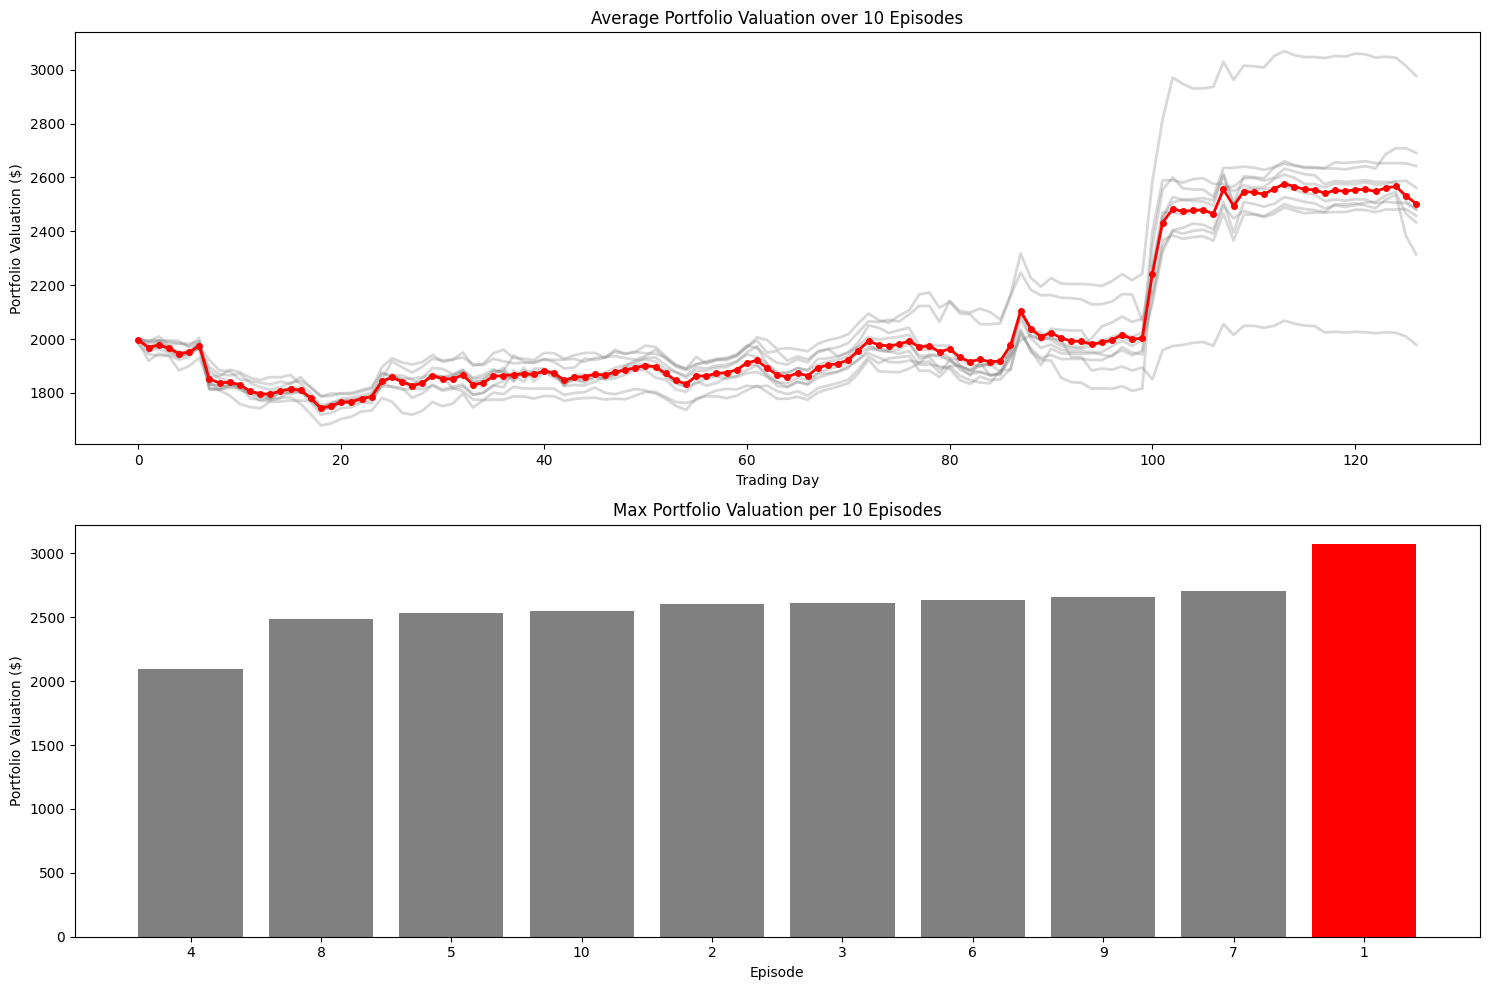

AVERAGE VALUATION: 2029.317
AVERAGE MAX VALUATION: 2594.965
ON AVERAGE, AGENT BOUGHT 120 TIMES AND SOLD 261 TIMES
Buy actions: [119, 120, 132, 115, 122, 119, 109, 123, 110, 131]
Sell actions: [262, 261, 249, 266, 259, 262, 272, 258, 271, 250]
Average buy percents: [0.495, 0.493, 0.483, 0.524, 0.471, 0.517, 0.485, 0.511, 0.476, 0.504]
Average sell percents: [0.626, 0.668, 0.655, 0.639, 0.631, 0.649, 0.652, 0.678, 0.659, 0.701]


In [11]:
#Render Performance
fun = make_env(0)
env = fun()
mon_env = Monitor(env)

obs = env.reset()
env.set_render_episodes(True)
mean_reward, std_reward = evaluate_policy(
    ppo_model, mon_env, n_eval_episodes=10, deterministic=False)
env.unwrapped.render(mode="review")

______________________________________________________________________________________________________________________________________________________________________________________________
# Create TRPO model
______________________________________________________________________________________________________________________________________________________________________________________________

## Setup model and parameters

In [56]:
#Set Parameters
n_steps = 2048 #Default rollout size for TRPO
num_cpus = 8 #Number of parallel environments (May need to reduce to 2 to run effectively run on colab)
n_epochs = 128 #Number of rollouts

#Setup Parallel Environments
vec_env = SubprocVecEnv([make_env(i) for i in range(num_cpus)])

#Create model
trpo_model = TRPO(policy="MlpPolicy", env=vec_env, learning_rate=linear_schedule(1e-3, 1e-4))

## Train TRPO model

In [ ]:
#Train model
total_timesteps = num_cpus*n_steps*n_epochs
callback = ProgressCallback(total_timesteps, num_cpus)

trpo_model.learn(total_timesteps, callback)

## Load TRPO model

In [58]:
trpo_model = TRPO.load("trpo_agent")

c:\Users\jgh\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object learning_rate. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\jgh\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


## Render TRPO performance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


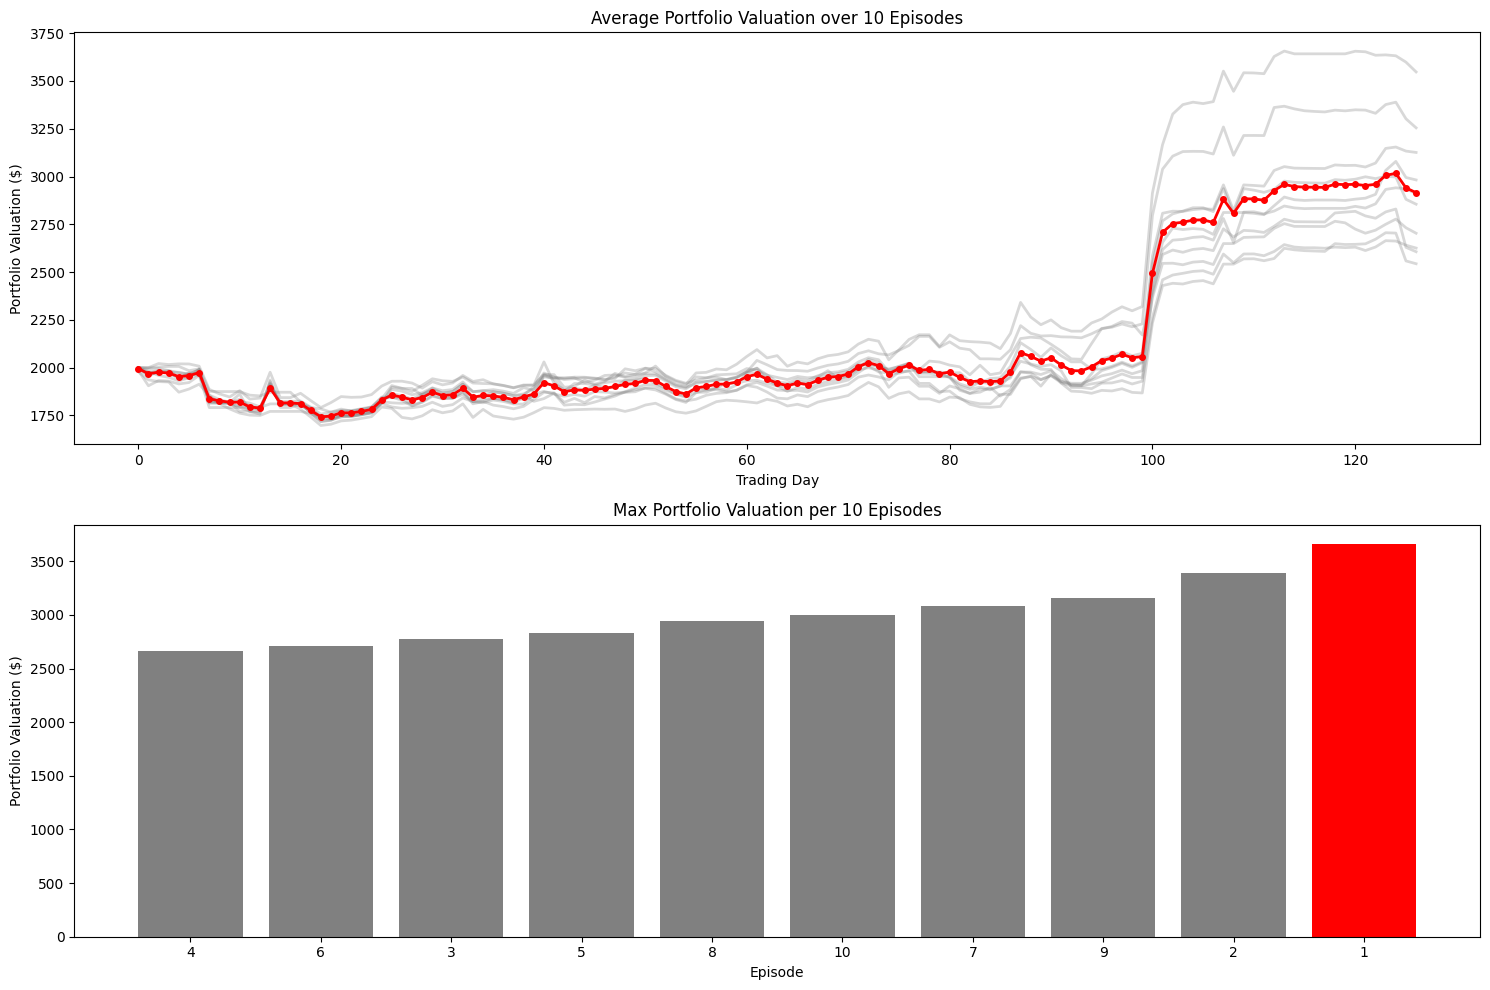

AVERAGE VALUATION: 2118.691
AVERAGE MAX VALUATION: 3019.79
ON AVERAGE, AGENT BOUGHT 138 TIMES AND SOLD 243 TIMES
Buy actions: [138, 136, 146, 139, 139, 144, 133, 137, 127, 141]
Sell actions: [243, 245, 235, 242, 242, 237, 248, 244, 254, 240]
Average buy percents: [0.625, 0.593, 0.613, 0.636, 0.608, 0.623, 0.611, 0.638, 0.615, 0.614]
Average sell percents: [0.725, 0.742, 0.741, 0.739, 0.731, 0.764, 0.743, 0.748, 0.741, 0.766]


In [76]:
#Render Performance
fun = make_env(0)
env = fun()
mon_env = Monitor(env)

obs = env.reset()
env.set_render_episodes(True)
mean_reward, std_reward = evaluate_policy(
    trpo_model, mon_env, n_eval_episodes=10, deterministic=False)
env.unwrapped.render(mode="review")

______________________________________________________________________________________________________________________________________________________________________________________________
# Create TD3 model
______________________________________________________________________________________________________________________________________________________________________________________________

## Create model and setup parameters

In [53]:
#Set Parameters
n_steps = 2048 #Default rollout size for TRPO
num_cpus = 1 #Number of parallel environments (Must equal to 1, cannot run environments in parallel for TD3)
n_epochs = 128 #Number of rollouts

#Setup Parallel Environments
vec_env = SubprocVecEnv([make_env(i) for i in range(num_cpus)])

# Setup action noise
n_actions = vec_env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

#Create model
td3_model = TD3(policy="MlpPolicy", env=vec_env, verbose=1, learning_rate=linear_schedule(1e-3, 1e-4), action_noise=action_noise)

Using cuda device


## Train TD3 model

In [ ]:
#Train model
total_timesteps = num_cpus*n_steps*n_epochs
callback = ProgressCallback(total_timesteps, num_cpus)

td3_model.learn(total_timesteps, callback)

## Load TD3 model

In [54]:
td3_model = TD3.load("td3_agent")

## Render TD3 performance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


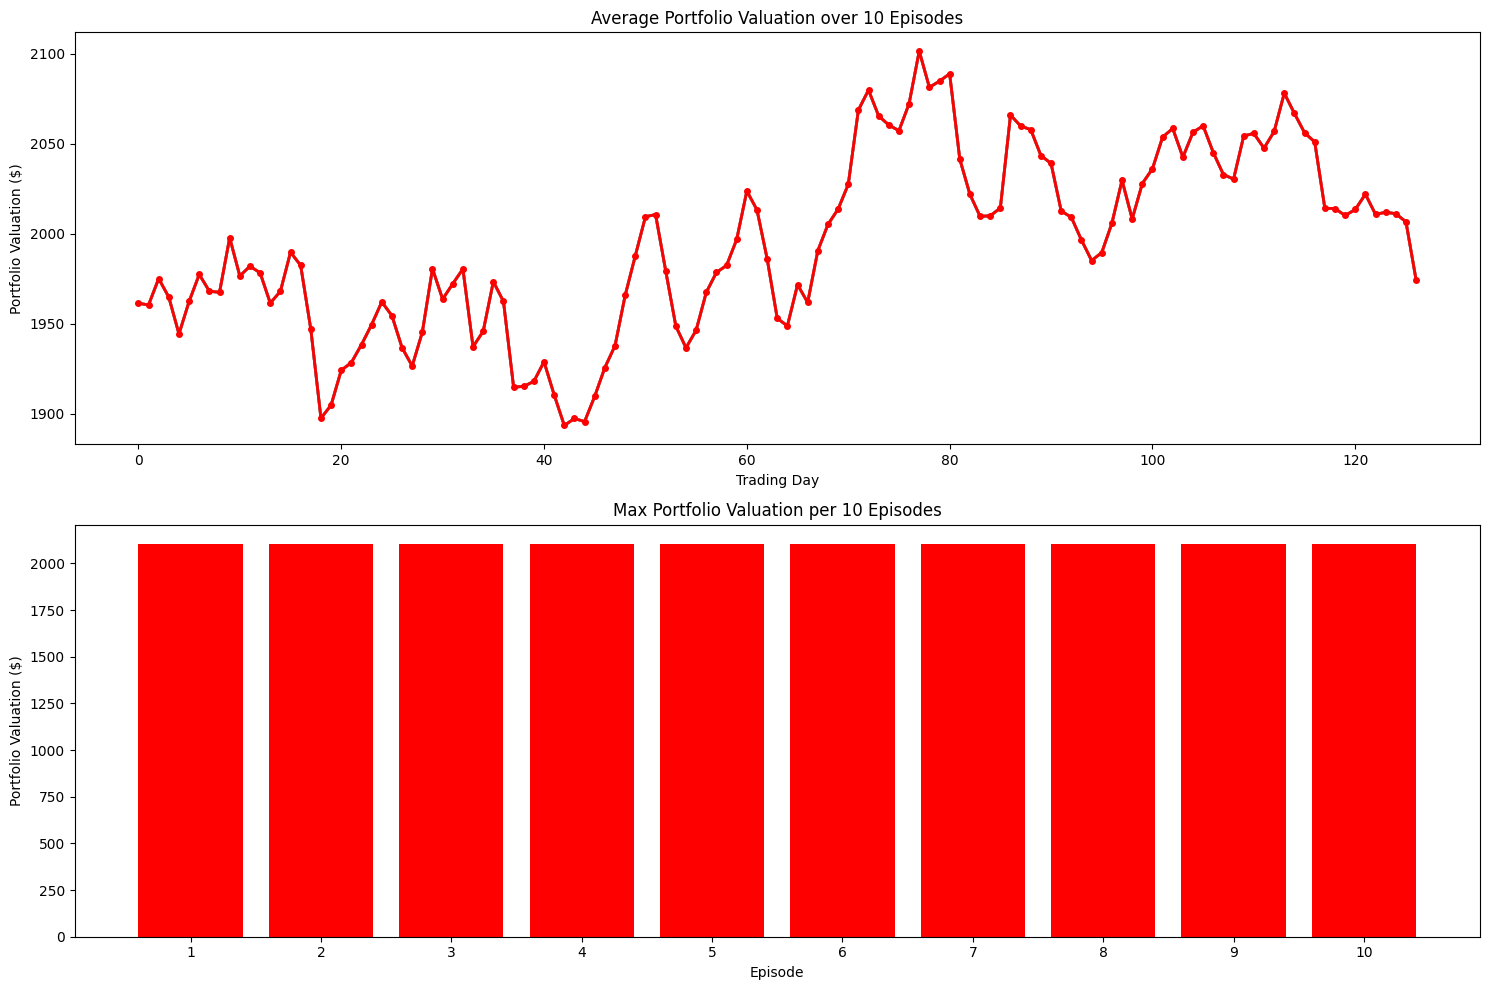

AVERAGE VALUATION: 1994.179
AVERAGE MAX VALUATION: 2101.37
ON AVERAGE, AGENT BOUGHT 381 TIMES AND SOLD 0 TIMES
Buy actions: [381, 381, 381, 381, 381, 381, 381, 381, 381, 381]
Sell actions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Average buy percents: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average sell percents: []


In [77]:
#Render Performance
fun = make_env(0)
env = fun()
mon_env = Monitor(env)

obs = env.reset()
env.set_render_episodes(True)
mean_reward, std_reward = evaluate_policy(
    td3_model, mon_env, n_eval_episodes=10, deterministic=False)
env.unwrapped.render(mode="review")

______________________________________________________________________________________________________________________________________________________________________________________________
## Create optimal TRPO model
______________________________________________________________________________________________________________________________________________________________________________________________

## Setup parameters

This final TRPO model has only 1 changed hyperparameter as it was the only change which was found to improve performance. The gae_lambda value was increased from the default 0.95 to 0.99

In [63]:
#Set Parameters
n_steps = 2048 #Default rollout size for TRPO
num_cpus = 8 #Number of parallel environments (May need to reduce to 2 to run effectively run on colab)
n_epochs = 128 #Number of rollouts

#Setup Parallel Environments
vec_env = SubprocVecEnv([make_env(i) for i in range(num_cpus)])

#Create model
final_model = TRPO(policy="MlpPolicy", env=vec_env, learning_rate=linear_schedule(1e-3, 1e-4), gae_lambda=0.99)

## Train TRPO model

In [ ]:
#Train model
total_timesteps = num_cpus*n_steps*n_epochs
callback = ProgressCallback(total_timesteps, num_cpus)

final_model.learn(total_timesteps, callback)

## Load trained Model

In [64]:
#Load agent
final_model = TRPO.load("Final_model")

## Run agent and evaluate performance

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


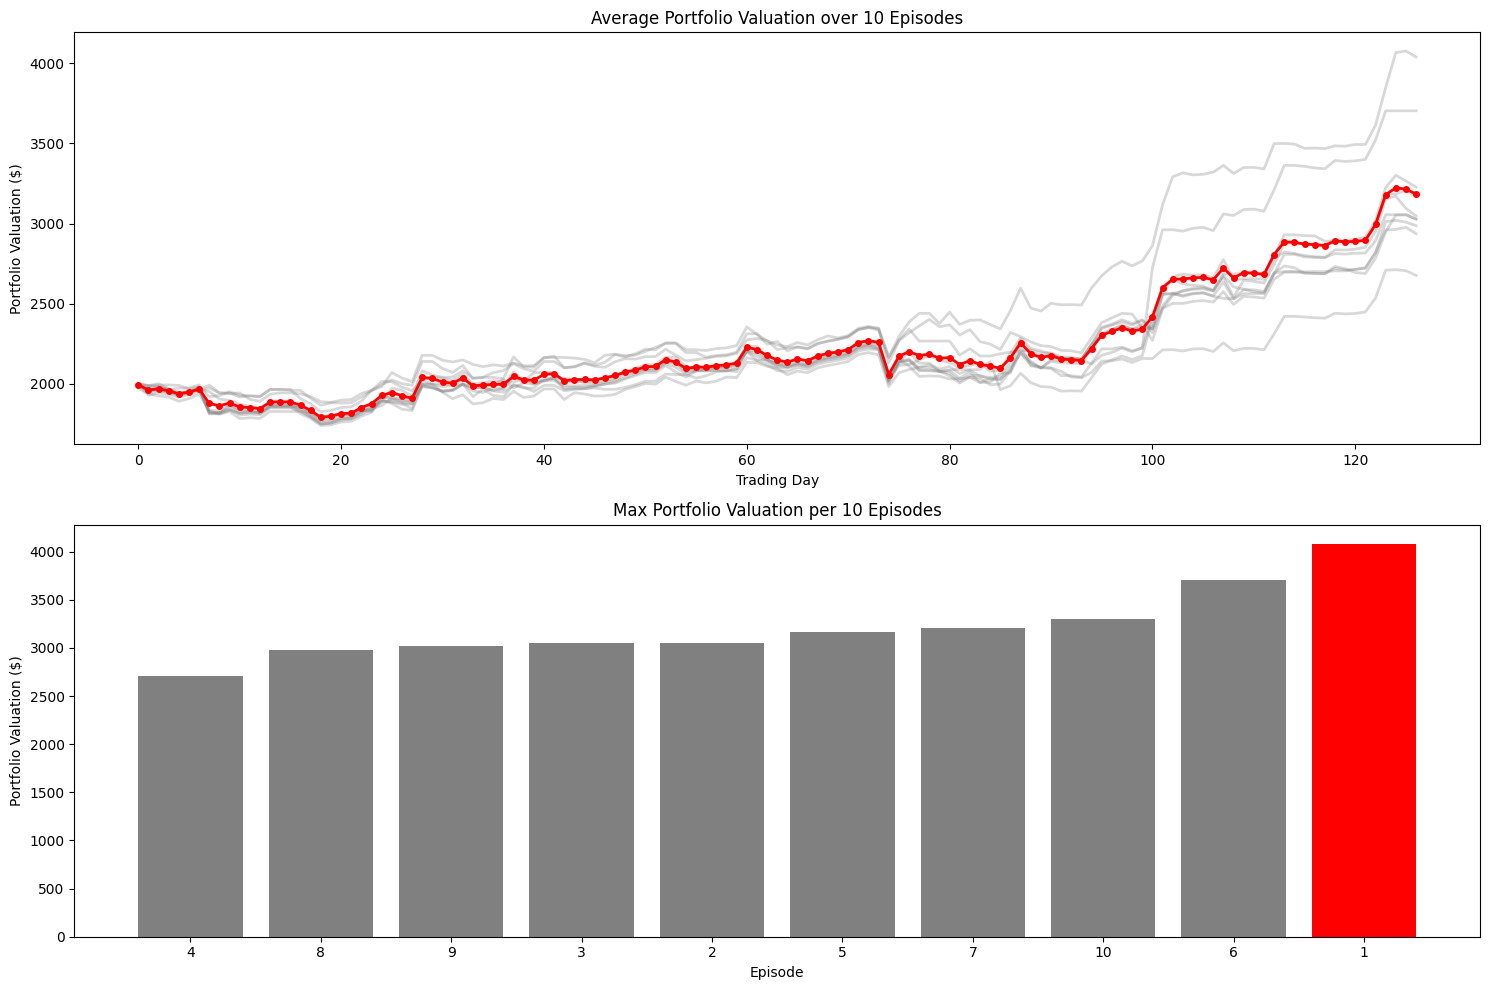

AVERAGE VALUATION: 2226.866
AVERAGE MAX VALUATION: 3227.364
ON AVERAGE, AGENT BOUGHT 126 TIMES AND SOLD 254 TIMES
Buy actions: [128, 129, 130, 134, 129, 120, 121, 123, 118, 133]
Sell actions: [253, 252, 251, 247, 252, 261, 260, 258, 263, 248]
Average buy percents: [0.618, 0.602, 0.667, 0.578, 0.573, 0.686, 0.619, 0.651, 0.617, 0.663]
Average sell percents: [0.742, 0.769, 0.758, 0.769, 0.726, 0.743, 0.758, 0.752, 0.738, 0.8]


In [78]:
#Render Performance
fun = make_env(0)
env = fun()
mon_env = Monitor(env)

obs = env.reset()
env.set_render_episodes(True)
mean_reward, std_reward = evaluate_policy(
    final_model, mon_env, n_eval_episodes=10, deterministic=False)
env.unwrapped.render(mode="review")

______________________________________________________________________________________________________________________________________________________________________________________________
## Compare performance of all models
______________________________________________________________________________________________________________________________________________________________________________________________

This cell will display the average performance of each of the three basic models as well as the final model on a single graph

This cell requires that each of the previous render functions have been run in sequential order (PPO, TRPO, TD3, Final model) as the render function saves the performance to model_performances.csv, and this cell will load the values from the file in that order

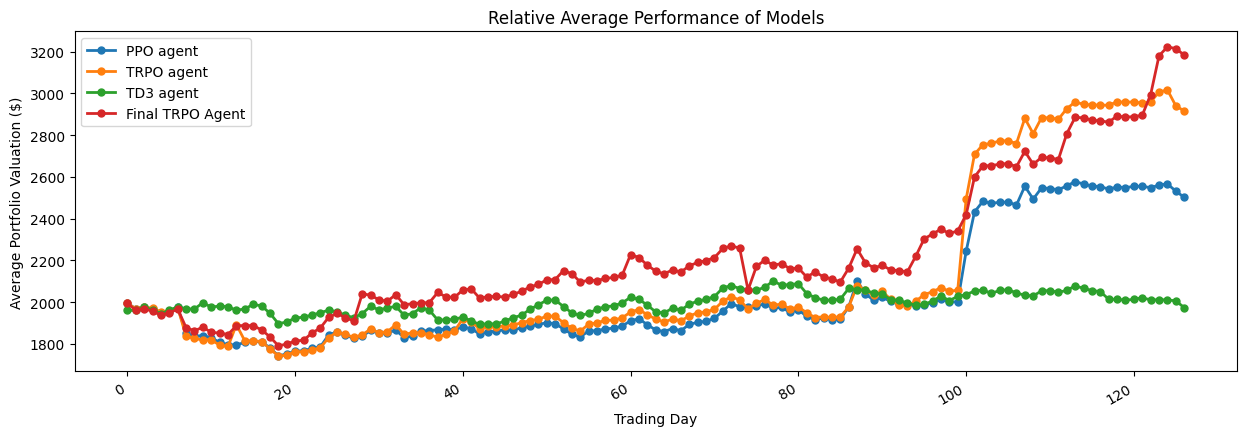

In [79]:
def plot_model_perf(fname, labels):
    
    data = pd.read_csv(fname, header = None)
    data.columns = [f"{day}" for day in range(data.shape[1])]
    
    plt.figure(figsize=(15, 5))
    
    cmap = cm.tab10
    
    for idx, row in data.iterrows():
        plt.plot(row, linewidth = 2, marker = "o", markersize = 5, label = labels[idx], color = cmap(idx % 10))
        
    plt.title("Relative Average Performance of Models")
    
    x_ticks = list(range(0, len(data.columns), 20))
    
    plt.xticks(x_ticks, [data.columns[tick] for tick in x_ticks])
    
    plt.gcf().autofmt_xdate()
    
    plt.xlabel("Trading Day")
    plt.ylabel("Average Portfolio Valuation ($)")
    
    plt.legend()
    
    plt.savefig("all_agents_performance.png", bbox_inches = "tight")
    plt.show()
    
labels = ["PPO agent", "TRPO agent", "TD3 agent", "Final TRPO Agent"]
    
plot_model_perf("model_performances.csv", labels)